In [1]:
from IPython.display import HTML
HTML(open('../style.css').read())

# Dealing with Conflicts

This file shows how `Ply` deals with *shift-reduce* and *reduce-reduce* conflicts.
The following grammar is *ambiguous* because it does not specify the precedence of the arithmetical operators:
```
    expr : expr '+' expr
         | expr '*' expr
         | NUMBER      
         ;
```

## Specification of the Scanner

We implement a minimal scanner for arithmetic expressions.

In [2]:
import ply.lex as lex

tokens = [ 'NUMBER' ]

def t_NUMBER(t):
    r'0|[1-9][0-9]*'
    t.value = int(t.value)
    return t

literals = ['+', '*']

t_ignore = ' \t'

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count('\n')

def t_error(t):
    print(f"Illegal character '{t.value[0]}'")
    t.lexer.skip(1)

__file__ = 'main'

lexer = lex.lex()

## Specification of the Parser

In [3]:
import ply.yacc as yacc

The *start variable* of our grammar is `expr`, but we don't have to specify that.  The default
start variable is the first variable that is defined.

We can specify multiple expressions in a single rule.  In this case, we have used the `pass`statement 
as we just want to generate the *shift/reduce conflicts* that are associated with this grammar. 

In [ ]:
def p_expr(p):
    """
    expr : expr '+' expr
         | expr '*' expr
         | NUMBER            
    """
    pass
 

If we want to generate a parse tree, we have to do more work.

In [4]:
def p_expr_plus(p):
    "expr : expr '+' expr"
    p[0] = ('+', p[1], p[3])
    
def p_expr_mult(p): 
    "expr : expr '*' expr"
    p[0] = ('*', p[1], p[3])
    
def p_expr_NUMBER(p):
    "expr : NUMBER"
    p[0] = p[1]

We define `p_error`in order to prevent a warning.

In [5]:
def p_error(p):
    print(f'Syntax error.')

Setting the optional argument `write_tables` to `False` <B style="color:red">is required</B> to prevent an obscure bug where the parser generator tries  to read an empty parse table.

In [6]:
yacc.yacc(write_tables=False, debug=True);

Generating LALR tables


Let's look at the action table that is generated.  Note that all *conflicts are resolved in favour of shifting*.

In [7]:
!cat parser.out

Created by PLY version 3.11 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> expr
Rule 1     expr -> expr + expr
Rule 2     expr -> expr * expr
Rule 3     expr -> NUMBER

Terminals, with rules where they appear

*                    : 2
+                    : 1
NUMBER               : 3
error                : 

Nonterminals, with rules where they appear

expr                 : 1 1 2 2 0

Parsing method: LALR

state 0

    (0) S' -> . expr
    (1) expr -> . expr + expr
    (2) expr -> . expr * expr
    (3) expr -> . NUMBER

    NUMBER          shift and go to state 2

    expr                           shift and go to state 1

state 1

    (0) S' -> expr .
    (1) expr -> expr . + expr
    (2) expr -> expr . * expr

    +               shift and go to state 3
    *               shift and go to state 4


state 2

    (3) expr -> NUMBER .

    +               reduce using rule 3 (expr -> NUMBER .)
    *               reduce using rule 3 (expr -> NUMBER .)
    $end            reduce 

In [8]:
%run ../AST2Dot.ipynb

The function `test(s)` takes a string `s` as its argument an tries to parse this string.  If all goes well, an abstract syntax tree is returned.
If the string can't be parsed,  an error message is printed by the parser.

In [9]:
def test(s):
    t = yacc.parse(s)
    d = tuple2dot(t)
    display(d)
    return t

The next example shows that this parser does not produce the abstract syntax that reflects the precedences of the arithmetical operators.

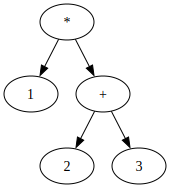

('*', 1, ('+', 2, 3))

In [10]:
test('1*2+3')

Due to the fact that all shift-reduce conflicts are resolved in favor of shift, all operators have the same precedence and effectively associate to the right.

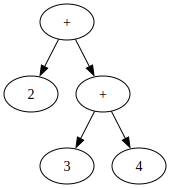

('+', 2, ('+', 3, 4))

In [11]:
test('2+3+4')

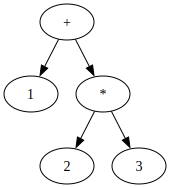

('+', 1, ('*', 2, 3))

In [12]:
test('1+2*3')